In [1]:
# 导入需要用到的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import time

warnings.filterwarnings('ignore')

# 设置matplotlib正常显示中文和负号
plt.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
plt.rcParams['axes.unicode_minus']=False     # 正常显示负号

In [2]:
# 读取数据并查看数据信息
rent_train = pd.read_csv('../../dataset/RentForecast/train_data.csv')
rent_train['Type'] = 'Train'
rent_test = pd.read_csv('../../dataset/RentForecast/test_a.csv')
rent_test['Type'] = 'Test'
target_train = rent_train['tradeMoney']

rent_alldata = pd.concat([rent_train, rent_test], ignore_index=True)
rent_alldata.head()

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0,Train
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0,Train
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0,Train
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0,Train
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0,Train


In [3]:
# 缺失值分析
def missing_values(data):
    analysis_na = pd.DataFrame(data.isnull().sum(), columns={'missingNum'})
    analysis_na['existingNum'] = len(data) - analysis_na['missingNum']
    analysis_na['sum'] = len(data)
    analysis_na['missingRatio'] = analysis_na['missingNum'] / analysis_na['sum'] * 100
    analysis_na['dtype'] = data.dtypes
    analysis_na = analysis_na[analysis_na['missingNum'] > 0].reset_index().sort_values(['missingNum', 'index'], ascending=[False, True])
    analysis_na.set_index('index', inplace=True)
    return analysis_na

# 对单调特征列进行探究----
def monotony(data):
    mono_list = []
    feature_col = [col for col in data.columns]
    for col in feature_col:
        flag = 0    # 记录特征的单调个数
        vals = data[col].values    
        len_ = len(vals)    
        for i in range(len_ -1):
            if vals[i+1] > vals[i]:
                flag += 1
            
        # 判断是否具备单调性
        if flag / data.shape[0] >= 0.55:
            print('单调特性：', col)
            print('单调个数：', flag)
            print('单调特征值比例：', flag / data.shape[0])
            mono_list.append(col)
    
    return mono_list

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import pickle
import multiprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LinearRegression, LogisticRegression

In [5]:
# 数据预处理
def ProcessingData(data):
    # 缺失值处理
    data['rentType'][data['rentType'] == '--'] = '未知方式'
    
    # 类别型数据转换
    columns = ['rentType', 'houseType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    
    for co in columns:
        data[co] = LabelEncoder().fit_transform(data[co])
        
    # 将buildYear转换为整型
    buildYearMode = pd.DataFrame(data[data['buildYear'] != '暂无信息']['buildYear'].mode())
    data.loc[data[data['buildYear'] == '暂无信息'].index, 'buildYear'] = buildYearMode.iloc[0, 0]
    data['buildYear'] = data['buildYear'].astype('int')
    
    # 处理pv和uv的空值，用该特征的均值替换
    data['pv'].fillna(data['pv'].mean(), inplace=True)
    data['uv'].fillna(data['uv'].mean(), inplace=True)
    data['pv'] = data['pv'].astype('int')
    data['uv'] = data['uv'].astype('int')
    
    # 分割交易时间，将交易时间‘2018-1-12'分割为年、月、日
    data['tradeTime'] = pd.to_datetime(data['tradeTime'])
    data['TradeYear'] = data['tradeTime'].dt.year
    data['tradeMonth'] = data['tradeTime'].dt.month
    data['tradeDay'] = data['tradeTime'].dt.day
    
    # 去除作用不大的特征
    data.drop(['ID', 'city'], axis=1, inplace=True)
    
    return data

data_train = ProcessingData(rent_train)

In [6]:
data_train.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type,TradeYear,tradeMonth,tradeDay
0,68.06,2,12,1,16,6,0,50,0,63,...,111546,1124,284,0,2018-11-28,2000.0,Train,2018,11,28
1,125.55,2,28,0,14,6,2,129,1,48,...,157552,701,22,1,2018-12-16,2000.0,Train,2018,12,16
2,132.00,2,28,1,32,6,0,178,1,49,...,131744,57,20,1,2018-12-22,16000.0,Train,2018,12,22
3,57.00,2,4,0,17,6,3,312,1,50,...,253337,888,279,9,2018-12-21,1600.0,Train,2018,12,21
4,129.00,2,29,1,2,6,1,1256,2,43,...,125309,2038,480,0,2018-11-18,2900.0,Train,2018,11,18


Int64Index([   62,    69,   128,   131,   246,   261,   266,   297,   308,
              313,
            ...
            39224, 39228, 39319, 39347, 39352, 39434, 39563, 41080, 41083,
            41233],
           dtype='int64', length=403)


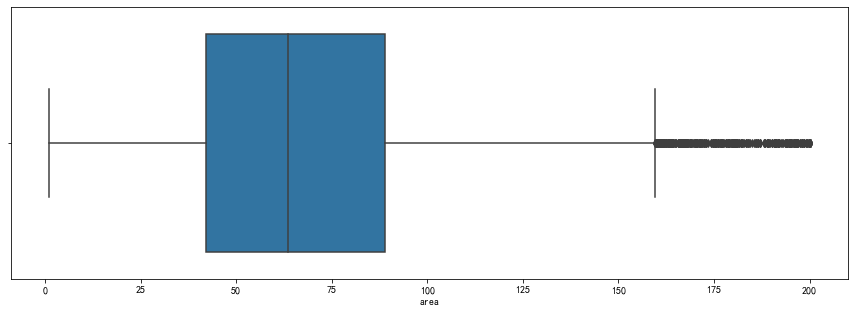

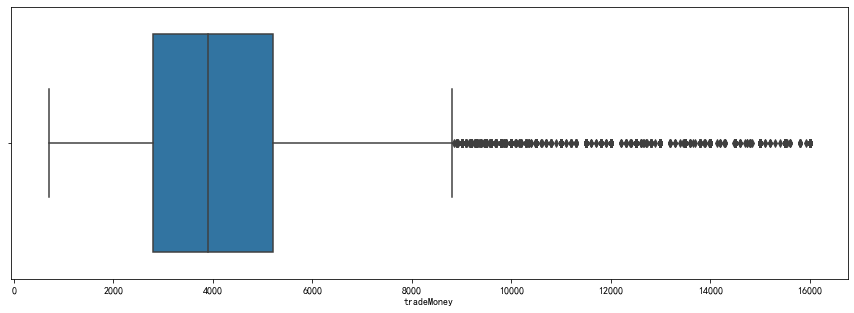

In [7]:
# 采用IsolationForest处理tradeMoney特征的异常值
def IF_drop(data):
    IForest = IsolationForest(contamination=0.01)
    IForest.fit(data['tradeMoney'].values.reshape(-1, 1))
    y_pred = IForest.predict(data['tradeMoney'].values.reshape(-1, 1))
    drop_index = data.loc[y_pred==-1].index
    print(drop_index)
    data.drop(drop_index, inplace=True)
    return data

rent_train = IF_drop(rent_train)

# 从area、tradeMoney、tradeFloor等特征处理异常值
def dropData(data):
    data = data[data['area'] <= 200]
    data = data[(data['tradeMoney'] <= 16000) & (data['tradeMoney'] >= 700)]
    data.drop(data[(data['totalFloor'] == 0)].index, inplace=True)
    return data

rent_train = dropData(rent_train)

# 查看处理异常值后的特征分布
plt.figure(figsize=(15, 5))
sns.boxplot(rent_train.area)
plt.show()
plt.figure(figsize=(15, 5))
sns.boxplot(rent_train.tradeMoney)
plt.show()

In [8]:
# 对每个region数据，对area和tradeMoney两个维度进行深度清洗
def cleanData(data):
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

rent_train = cleanData(rent_train)

In [9]:
# 特征处理与合并
def featureDealed(data):
    
    # 将houseType转为'Room','Hall','Bath'
    def Room(x):
        Room = int(x.split('室')[0])
        return Room
    def Hall(x):
        Hall = int(x.split('室')[1].split('厅')[0])
        return Hall
    def Bath(x):
        Bath = int(x.split('室')[1].split('厅')[1].split('卫')[0])
        return Bath
    
    data['Room'] = data['houseType'].apply(lambda x : Room(x))
    data['Hall'] = data['houseType'].apply(lambda x : Hall(x))
    data['Bath'] = data['houseType'].apply(lambda x : Bath(x))
    
    # Room和Bath之间的数量关系，+1是为了避免0值导致出现计算错误
    data['Room_Bath'] = (data['Bath']+1) / (data['Room']+1)
    
    # 依据Room，Room_Bath，area来填充租房的类型
    data.loc[(data['rentType'] == '未知方式') & (data['Room'] <= 1), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['Room_Bath'] > 1), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['Room'] > 1) & (data['area'] < 50), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] / data['Room'] < 20), 'rentType'] = '合租'
    # data.loc[(data['rentType']=='未知方式')&(data['area']>60),'rentType']='合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 50) & (data['Room'] == 2), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 2), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 60) & (data['Room'] == 3), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 3), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] >= 100) & (data['Room'] > 3), 'rentType'] = '整租'
    
    # data.drop('Room_Bath', axis=1, inplace=True)
    data['PV/UV'] = data['pv'] / data['uv']
    data['totalRoomNum'] = data['Room'] + data['Hall'] + data['Bath']
    
    # 合并部分配套设施特征，将小区附近设施数量与整个区域的均值作对比
    # 配套设施--交通方面-地铁站+公交站
    
    
    # 配套设施--学校数量
    
    
    # 配套设施--医疗数量
    
    
    # 配套设施--商城数量
    
    
    # 配套设施--其他配套（体育馆、银行、便利店、公园）
    
    
    
    categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate','cluster']
    return data, categorical_feats